# Capstone Project - Ho Chi Minh city district land price prediction
### Applied Data Science Capstone by IBM/Coursera

------
## Table of contents

* [Introduction: Business Problem](#introduction)
* [Data](#data)
    * [Land prices](#price)
    * [Filtering data](#filter)
    * [Boundaries](#boundaries)
    * [Landmarks](#landmark)
    * [Distance](#distance)
* [Methodology](#methodology)
* [Data Analysis](#analysis)
     * [Model](#model)
     * [Accuracy](#accuracy)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we aim to measure, as accurately as possible, the effects of **landmarks** such as hotels and restaurants on the **price of land** in districts in the city center of **Ho Chi Minh city, Vietnam**.

This model is useful for stakeholders interested in predicting price changes in land when new landmarks are built, whether to anticipate the rise and fall of their property prices when facilities are built nearby, or to raise their land values by building the optimal number of facilities.

To build this model, we will have to gather data on the landmarks of all districts, as well as their land prices. We will then construct a model that factors in different types of landmarks and how they affect the land prices. 

When the model is complete, stakeholders can simply modify the existing data to predict price changes, or insert their own data to predict land prices of their planned projects based on the number of facilities they're anticipating to build.

-----

## Data <a name="data"></a>

The data we require includes:
* The average land price of each district in Ho Chi Minh city
* The number and types of landmarks in an average area of each district
* The location of each district
* The boundaries of each district
* The distance of each district to the city center (district 1)

We will use a circle of suitable size, chosen to not exceed the district boundary, to define the area to gather landmark data.

The following data sources will be used to gather information:
* The average land prices in each district will be provided by a very well-known Vietnamese real estate website: **mogi.vn**
* The number and types of landmarks of the defined area will be provided by **Foursquare API**
* The coordinates of each district will be provided by **Google Maps API geocoding**
* The boundaries of each district will be gathered on **Google** and drawn onto a geojson
* The distance to the city center can be calculated using their coordinates

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json

!pip install geopy
from geopy.geocoders import Nominatim

import requests 
from pandas.io.json import json_normalize

!pip install folium
import folium

!pip install geopandas

     |████████████████████████████████| 102kB 10.4MB/s ta 0:00:01
     |████████████████████████████████| 972kB 9.0MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 49.8MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 45.2MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 45.5MB/s eta 0:00:01


In [2]:
!pip install lxml
import requests
import lxml.html as lh

### Land prices <a name="price"></a>

Let's start by extracting the landprices from the real estate website to create a dataframe.

In [3]:
url= "https://mogi.vn/gia-nha-dat"
page = requests.get(url)
doc = lh.fromstring(page.text)

In [4]:
# extract district names into a list
path="//div[contains(@class, 'mt-street')]"
elements = doc.xpath(path)
district =[]
for div in doc.xpath(path):
    district.append(div.text_content().strip('\n'))
del district[25:]
del district[0]

#extract prices into a list
sp_elements = doc.xpath('//span')
price=[]
for i in range(24):
    value=sp_elements[19+i].text_content().replace(' triệu/m2','')
    value=float(value.replace(',','.'))*1000000
    int(value)
    price.append(value)

#turn both lists into a dictionary
col=[]
col.append(("District",district))
col.append(("Price per square meter", price))
Dict={title:column for (title,column) in col}

#turn dictionary into dataframe, then print dataframe
df=pd.DataFrame(Dict)
df

,District,Price per square meter
0,Quận 1,418000000.0
1,Quận 2,81500000.0
2,Quận 3,265000000.0
3,Quận 4,109000000.0
4,Quận 5,254000000.0
5,Quận 6,114000000.0
6,Quận 7,90600000.0
7,Quận 8,70900000.0
8,Quận 9,48800000.0
9,Quận 10,211000000.0


### Filtering Data <a name="filter"></a>

In order to create an accurate model, we must only take relevant data and eliminate as many outliers as possible before we begin data analysis.

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.invert.vn/media/uploads/uploads/17210402-ban-do-vi-tri-ho-chi-minh.jpg")

This is a map of Ho Chi Minh city, Vietnam taken from a website.

From here, we can tell which districts belong to the city center and which ones does not.

The suburbs surrounding the city center comprises of mostly empty land with very few landmarks of note. This is especially true to the southern area, which is a massive uninhabited salt marsh.

District 1 is considered the city center, therefore we will also be taking district 2, which is next to district 1, into account and elimiting Tan Phu district, which is too far away and is home to the poorest population.

Thus, the dataframe will be reduced to the 14 districts we will be using for the model,

In [6]:
df = df.drop(df.index[17:])
df = df.drop([df.index[8], df.index[11], df.index[12]])
df.reset_index(inplace = True)
del df['index']
df = df.set_index('District')
df

,Price per square meter
District,
Quận 1,418000000.0
Quận 2,81500000.0
Quận 3,265000000.0
Quận 4,109000000.0
Quận 5,254000000.0
Quận 6,114000000.0
Quận 7,90600000.0
Quận 8,70900000.0
Quận 10,211000000.0


### Boundaries <a name="boundaries"></a>

First let's find the coordinates of district 1 which is the central district.

In [7]:
address = "Quận 1"
locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))

Latitude = 10.7745397, Longitude = 106.69918361158545


Now, we will insert the geojson file into a folium map to see the district boundaries.

In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
map_place = folium.Map(location=[latitude, longitude], zoom_start=12)
ch_geo=json.load(streaming_body_1)
folium.GeoJson(ch_geo, name="geojson").add_to(map_place)
map_place

### Landmarks <a name="landmark"></a>

We will start by drawing a circle in each district.

Because we are working with average land prices, it would be more accurate to select an average area in each district.

Using Google Maps API to determine the coordinates of each district and draw a circle of suitable size to make sure it does not exceed the district boundaries.

Let's try drawing circles with a radius of 600m.

In [10]:
for (idx, row) in df.iterrows():
    address = idx
    location = locator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    folium.Circle([latitude, longitude],
                    radius=600
                   ).add_to(map_place)
map_place

We can see that the circles are within bounds for the most part.
Let's try using Foursquare API to draw all landmarks within these circles.

At the same time, we will create a dataframe of these landmarks.

In [11]:
CLIENT_ID = 'I0HKK3UQB5QFRG5BIHZKBICUXGSKC0V5SPEL4LOERRRX3AP1' # your Foursquare ID
CLIENT_SECRET = 'VJQJDDZ0VBYUMU1JSGDSNBVT1SN0DJFKF0LR4GP0BTKKW4BQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I0HKK3UQB5QFRG5BIHZKBICUXGSKC0V5SPEL4LOERRRX3AP1
CLIENT_SECRET:VJQJDDZ0VBYUMU1JSGDSNBVT1SN0DJFKF0LR4GP0BTKKW4BQ


In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
list_of_df = {}
for (idx, row) in df.iterrows():
    address = idx
    location = locator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    LIMIT = 100
    radius = 600
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT)
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']    
    venues = json_normalize(venues)
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues =venues.loc[:, filtered_columns]
    venues['venue.categories'] = venues.apply(get_category_type, axis=1)
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    for lat, lng, name, cat in zip(venues['lat'], venues['lng'], venues['name'], venues['categories']):
        label = '{}, {}'.format(name, cat)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_place)
    list_of_df[idx]=venues.drop('lat', 1).drop('lng', 1)

In [14]:
map_place

As we can see, while some of the circles do exceed district boundaries, none of the land marks obtained through Foursquare API falls outside of these boundaries.

Thus, 600m radius is a suitable choice.

While drawing landmark points on the map, we've also generated a dataframe of landmarks for each district.

Let's use the list of dataframes to generate a dataframe showing the types of landmark within each district's data circle, as well as the number of each type.

In [15]:
dist_count=pd.DataFrame()
for (idx, row) in df.iterrows():
    address = idx
    dist_temp = list_of_df[address].groupby('categories').nunique()
    dist_temp.index.name = None
    dist_temp.drop('categories', axis=1, inplace=True)
    dist = dist_temp.rename(columns={'name':address}).transpose()
    dist_count = pd.concat([dist_count, dist], sort=True).fillna(0)
dist_count = dist_count.astype(int)
dist_count.index.name = 'District'
dist_count

,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Badminton Court,Bakery,Bar,Basketball Stadium,Bed & Breakfast,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Convention Center,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food Truck,Fountain,French Restaurant,Furniture / Home Store,Golf Course,Grocery Store,Gym / Fitness Center,Hawaiian Restaurant,Hotel,Hotel Bar,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lounge,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Multiplex,Nightclub,Noodle House,North Indian Restaurant,Opera House,Outdoors & Recreation,Park,Piano Bar,Pizza Place,Plaza,Record Shop,Restaurant,Road,Rock Club,Salad Place,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theme Park,Travel Agency,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Yoga Studio
District,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Quận 1,1,0,1,2,0,0,2,0,1,0,1,2,1,2,10,1,0,0,3,1,7,0,0,0,1,1,0,0,0,1,1,1,0,0,1,3,0,0,0,0,1,10,1,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,2,0,0,0,3,1,1,1,1,0,1,0,2,0,0,2,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,2,0,0,1,0,0,1,1,9,1,0
Quận 2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Quận 3,0,0,5,4,1,0,1,0,0,0,1,0,0,0,5,0,0,0,0,0,7,0,0,1,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,2,0,0,0,0,0,0,0,1,1,0,3,1,0,0,1,1,0,1,0,0,0,0,2,0,0,0,0,1,0,0,0,2,0,2,0,3,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,1
Quận 4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0
Quận 5,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,4,0,0,3,0,1,0,0,1,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0
Quận 6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Quận 7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0
Quận 8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Quận 10,0,1,0,0,0,1,0,0,0,1,0,1,0,1,8,0,0,0,0,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,9,0,0


### Distance <a name="distance"></a>

We will now calculate the distance between each district to district 1 and put them into a dataframe

In [16]:
!pip install mpu

     |████████████████████████████████| 71kB 7.0MB/s eta 0:00:011


In [17]:
address = "quận 1"
location = locator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [18]:
import mpu

def distance_to_center(lat, lon):
    lat1 = lat
    lon1 = lon
    lat2 = 10.7745397
    lon2 = 106.69918361158545
    dist = mpu.haversine_distance((lat1, lon1), (lat2, lon2))
    return dist

In [19]:
list_of_distance=[]
list_of_district=[]
for (idx, row) in df.iterrows():
    address = idx
    location = locator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    dtc = distance_to_center(latitude, longitude)
    list_of_distance.append(dtc)
    list_of_district.append(idx)

In [20]:
col2=[]
col2.append(("District", list_of_district))
col2.append(("Distance", list_of_distance))
Dict2={title:column for (title,column) in col2}
df2=pd.DataFrame(Dict2)
df2.reset_index(inplace = True)
del df2['index']
df2 = df2.set_index('District')
df2

,Distance
District,
Quận 1,0.000000
Quận 2,4.496321
Quận 3,1.655846
Quận 4,1.811519
Quận 5,3.754218
Quận 6,7.704771
Quận 7,4.926774
Quận 8,5.260779
Quận 10,3.427838


Finally, we will put the price, landmarks and distance dataframes together.

In [21]:
df_merged = pd.DataFrame()
df_tempt = pd.merge(dist_count, df2, on= 'District')
df_merged = pd.merge(df_tempt, df, on='District')
df_merged

,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Badminton Court,Bakery,Bar,Basketball Stadium,Bed & Breakfast,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Convention Center,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food Truck,Fountain,French Restaurant,Furniture / Home Store,Golf Course,Grocery Store,Gym / Fitness Center,Hawaiian Restaurant,Hotel,Hotel Bar,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lounge,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Multiplex,Nightclub,Noodle House,North Indian Restaurant,Opera House,Outdoors & Recreation,Park,Piano Bar,Pizza Place,Plaza,Record Shop,Restaurant,Road,Rock Club,Salad Place,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theme Park,Travel Agency,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Yoga Studio,Distance,Price per square meter
District,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Quận 1,1,0,1,2,0,0,2,0,1,0,1,2,1,2,10,1,0,0,3,1,7,0,0,0,1,1,0,0,0,1,1,1,0,0,1,3,0,0,0,0,1,10,1,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,2,0,0,0,3,1,1,1,1,0,1,0,2,0,0,2,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,2,0,0,1,0,0,1,1,9,1,0,0.000000,418000000.0
Quận 2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4.496321,81500000.0
Quận 3,0,0,5,4,1,0,1,0,0,0,1,0,0,0,5,0,0,0,0,0,7,0,0,1,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,2,0,0,0,0,0,0,0,1,1,0,3,1,0,0,1,1,0,1,0,0,0,0,2,0,0,0,0,1,0,0,0,2,0,2,0,3,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,1,1.655846,265000000.0
Quận 4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1.811519,109000000.0
Quận 5,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,4,0,0,3,0,1,0,0,1,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,3.754218,254000000.0
Quận 6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.704771,114000000.0
Quận 7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,4.926774,90600000.0
Quận 8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.260779,70900000.0
Quận 10,0,1,0,0,0,1,0,0,0,1,0,1,0,1,8,0,0,0,0,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,9,0,0,3.427838,211000000.0


With that, we have a map of all the landmarks within a 600m circle of every district. We also have a dataframe of the number of each different type of landmark within a district, the distance between each district and district 1, as well as the average land price for the corresnponding district.

All the necessary data has been gathered. We will now put that data to good use.

------

## Methodology <a name="methodology"></a>

This project's ultimate goal is to create a model capable of predicting land prices based on the types and number of each type of landmarks in a district and also based on how far away that district is from the city center.

Data analysis will consist of creating a Regression Model.

Because of the nature of the data, Multiple Linear Regression is the most suitable model for this purpose. (Polynominal Regression has been tested and proven to be the inferior model, so it will not be presented in this case.)

We must also acknowledge the fact that the data sample is quite lacking and uneven. For example, a few populous districts near the city center contains the majority of landmarks in the dataset. Therefore, any uneven distribution of these districts between the train and test samples will create very inaccurate models.

Thus, we will calculate how accurate the current model is by calculating the accuracy of every possible cases.

-----

## Data Analysis <a name="analysis"></a>

### Model <a name="model"></a>

Let's look at the relationship between the distance to the city center and land price.

Text(0, 0.5, 'Price per square meter')

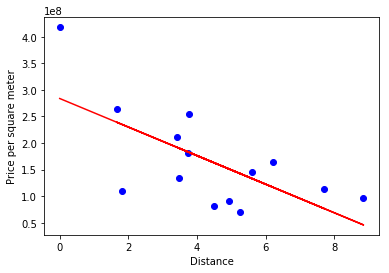

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(df_merged[['Distance']])
train_y = np.asanyarray(df_merged[['Price per square meter']])
regr.fit (train_x, train_y)
plt.scatter(df_merged['Distance'], df_merged['Price per square meter'],  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Distance")
plt.ylabel("Price per square meter")

Next let's create a dataframe based on a total number of landmarks in each district and plot a graph with it as well.

In [23]:
dl = pd.DataFrame(dist_count.transpose().sum())
dl.columns = ['count']
dl = pd.merge(dl, df, on='District')
dl

,count,Price per square meter
District,,
Quận 1,97,418000000.0
Quận 2,4,81500000.0
Quận 3,69,265000000.0
Quận 4,18,109000000.0
Quận 5,32,254000000.0
Quận 6,4,114000000.0
Quận 7,11,90600000.0
Quận 8,5,70900000.0
Quận 10,38,211000000.0


Text(0, 0.5, 'Price per square meter')

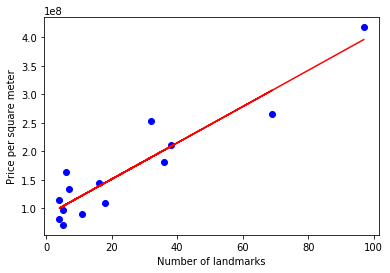

In [24]:
regr = linear_model.LinearRegression()
train_x = np.asanyarray(dl[['count']])
train_y = np.asanyarray(dl[['Price per square meter']])
regr.fit (train_x, train_y)
plt.scatter(dl['count'], dl['Price per square meter'],  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Number of landmarks")
plt.ylabel("Price per square meter")

As you can see, the graphs show a linear relationship. Multiple Linear Regression would be a very good choice.

We will start by creating a training and test set.
The amount of data distributed to each set will be selected at random.

In [25]:
msk = np.random.rand(len(df)) < 0.6
train = df_merged[msk]
test = df_merged[~msk]

list_of_columns = []
for col in df_tempt.columns:
    list_of_columns.append(col)

from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[list_of_columns])
y = np.asanyarray(train[['Price per square meter']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 3.62915385e+04  3.14321369e-09 -6.35398989e+05  4.25655380e+06
   6.99061736e+04 -1.86264515e-09  1.16371065e+06  0.00000000e+00
   3.62915385e+04 -1.02122140e+06  1.06197712e+05  2.11502587e+06
   1.05751293e+06  2.11502587e+06  3.99831835e+06  1.05751293e+06
  -1.02122140e+06 -2.04244279e+06  3.17253880e+06  1.05751293e+06
   5.80436743e+06 -4.58108704e+06 -1.02122140e+06  6.99061736e+04
   1.05751293e+06  1.12741911e+06 -1.02122140e+06  0.00000000e+00
   0.00000000e+00  2.91941618e+06 -8.96141776e+06  2.91941618e+06
   0.00000000e+00  0.00000000e+00  1.05751293e+06  3.38225732e+06
  -8.56756613e+05 -4.58108704e+06  0.00000000e+00  1.93180941e+06
   1.05751293e+06  8.67249890e+06  1.05751293e+06  0.00000000e+00
   0.00000000e+00  1.05751293e+06 -1.84168647e+06  1.05751293e+06
   1.05751293e+06  1.06197712e+05  6.99061736e+04 -8.56756613e+05
   2.09718521e+05  6.99061736e+04  0.00000000e+00  1.05751293e+06
   6.99061736e+04  6.99061736e+04  2.11502587e+06  6.99061736

Now we will evalue the model. Depending on how the training and testing set are split the variance score will change dramatically due to the small sample of data.

However, it should be above 0 most of the time

In [26]:
from sklearn.metrics import r2_score
y_hat= regr.predict(test[list_of_columns])
x = np.asanyarray(test[list_of_columns])
y = np.asanyarray(test[['Price per square meter']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 2667285942680664.50
Variance score: 0.36


### Accuracy <a name="accuracy"></a>

We will now create a dataframe to show how accurate our model is. This will also help evaluate whether the model has improved or worsened when more data is provided into the data set in the future.

There are 14 districts used in our data sample, and they can be used in either the test or the training set. We can view this as having a data point of either 0 or 1.

With 14 districts there are 2^14 combinations of 0s and 1s, we will now generate every possible combinations.

In [27]:
def get_bitstrings(length):  
  iterations = 2**length
  the_array = np.zeros((iterations, length))
  for num in range(iterations):
    # Get binary representation in string format with 'length' zeroes padded
    t_string = '{f_num:0{f_width}b}'.format(f_num=num, f_width=length)
    # Convert to a Python list
    t_list   = list(t_string)
    # Convert to Numpy array and store.
    the_array[num,:] = np.array(t_list)

  return the_array

In [28]:
all_combinations = get_bitstrings(14)
all_combinations

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

Next, we will create a dataframe based on these combinations. Note that 2 of them has to be removed, namely the one with all 0s and all 1s as this would mean either the test or train set would be empty.

In [29]:
combi_frame = pd.DataFrame(all_combinations).astype(int)

Dist = []
for i in range(14):
    Dist.append(df.index[i])

combi_frame.columns = Dist

combi_frame = combi_frame.drop(16383)
combi_frame = combi_frame.drop(0)

combi_frame.head()

,Quận 1,Quận 2,Quận 3,Quận 4,Quận 5,Quận 6,Quận 7,Quận 8,Quận 10,Quận 11,Quận Bình Thạnh,Quận Gò Vấp,Quận Phú Nhuận,Quận Tân Bình
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,1


We will use all these combinations and generate every possible variance score in a Multiple Linear Regression model

In [30]:
combi_list = combi_frame.values.tolist()

In [31]:
score=[]
for i in range (1,16382):
    bool_list = list(map(bool,combi_list[i]))
    train = df_merged[np.array(bool_list)]
    test = df_merged[~np.array(bool_list)]
    regr = linear_model.LinearRegression()
    x = np.asanyarray(train[list_of_columns])
    y = np.asanyarray(train[['Price per square meter']])
    regr.fit (x, y)
    y_hat= regr.predict(test[list_of_columns])
    x = np.asanyarray(test[list_of_columns])
    y = np.asanyarray(test[['Price per square meter']])
    score.append(regr.score(x, y))

In [32]:
score_frame = pd.DataFrame({'score':score})
score_frame.head()

,score
0,-0.029688
1,0.229938
2,-0.668511
3,0.371928
4,0.415022


Putting them together, we can make a dataframe showing the variance score of a model using every combination.

In [33]:
merged_frame = pd.merge(combi_frame,score_frame, left_index=True, right_index=True)
merged_frame.head()

,Quận 1,Quận 2,Quận 3,Quận 4,Quận 5,Quận 6,Quận 7,Quận 8,Quận 10,Quận 11,Quận Bình Thạnh,Quận Gò Vấp,Quận Phú Nhuận,Quận Tân Bình,score
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.229938
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.668511
3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.371928
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.415022
5,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.469667


Finally, we will generate a dataframe showing the score distribution.

In [34]:
#generate the percentage of scores by dividing the number of cases of a certain score by the total number of cases
percent = []
score_range = []
score_range.append('<0')
range_frame = score_frame.loc[score_frame['score'] < 0]
g = range_frame.shape[0]/16380*100
h = "%.2f" % g
percent.append(h)
for i in range(10):
    upper = (i+1)/10
    lower = i/10
    range_frame = score_frame.loc[(score_frame['score'] >= lower ) & (score_frame['score'] < upper)]
    g = range_frame.shape[0]/16380*100
    h = "%.2f" % g
    percent.append(h)
    string = str(lower) + ' <=x< ' +str(upper)
    score_range.append(string)
score_range

percentage = list(map("{}%".format, percent))
percentage

column_names=[]
column_names.append(("Score Range",score_range))
column_names.append(("Percentage", percentage))
accu_dict={title:column for (title,column) in column_names}

#turn dictionary into dataframe, then print dataframe
accuracy_board=pd.DataFrame(accu_dict)
accuracy_board.set_index('Score Range')

,Percentage
Score Range,
<0,23.83%
0.0 <=x< 0.1,5.48%
0.1 <=x< 0.2,6.20%
0.2 <=x< 0.3,7.60%
0.3 <=x< 0.4,9.82%
0.4 <=x< 0.5,11.79%
0.5 <=x< 0.6,15.39%
0.6 <=x< 0.7,10.78%
0.7 <=x< 0.8,6.89%


-----

## Results and Discussion <a name="results"></a>

Through Data analysis we were able to construct a moderately accurate model capable of predicting land prices in the central districts of Ho Chi Minh city, Vietnam. We also produced a dataframe which will show us how the accuracy will change as more data is collected.

Based on the coefficients of the model, we can also safely say most of these landmarks, as well as the distance of the district to the city center, have a fairly significant effect on the price of the land.

The model is far from complete, however, and requires more data.

Due to the nature of Vietnamese addresses, Foursquare API was unable to identify each landmark by district, making it difficult to include as many landmarks as possible in each district. Furthermore, Foursquare API was unable to identify all landmarks in a given area, even fairly famous landmarks such as Ben Thanh market in district 1.

Vietnamese districts are also distributed and has boundaries drawn in no particular order, there is no logic to their size and placements other than history. As such it was too difficult to try covering the entirety of the area in each district.

The combination of these two factors has proven detrimental to the model building process. Thus, more extensive and accurate data is required to further enhance the accuracy of the model. Currently, the model above has proven to be at least somewhat accurate in predicting test set prices, further testing on real data sets is required for refinement.

-----

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify the different types of landmarks in the central districts of Ho Chi Minh city, Vietnam and gauge their effects on land prices while using their distance to the city center as a factor to improve accuracy. This is to aid stakeholders who have, or are wishing to invest in real estate in Ho Chi Minh city.

With this model, they will be able to predict the change in land prices as landmarks are built and/or demolished in each district and make more accurate judgements on landprices they're about to buy or sell.